### Predicting Customer Churn in a Telecom Company
 

Natalia Block

Business problem: customer churn of a telecom company. What make clients 
quit the service? The objective is to build a machine learning model to predict if a client will cancel the service and the factors that influence clients' decision. With these answers in hand I'll make some recommendations to improve the services and avoid/reduce churn in the future.

##### Step 1: Exploratory analysis

In [1]:
#importing the packages 
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE, SelectKBest, chi2 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import matplotlib.pyplot as plt

Training and test datasets were provided separately. I'll do some explorations in the training dataset

In [2]:
#uploading csv file with pandas and taking a look at the shape
#of the training dataset
data_train= 'projeto4_telecom_treino.csv'
data_test= 'projeto4_telecom_teste.csv'
train= pd.read_csv(data_train)
test= pd.read_csv(data_test)

print(train.shape)


(3333, 21)


In [3]:
#Taking a look at the first five lines
train.head(5)

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


#### The dataset has the following input variables:

1. unnamed(probably the customer identifier)

2. state: US state

3. account_lenght: probably the tenure of the account. No idea of the time unit(months? days? I'm guessing it's months)

4. area_code

5. international_plan (yes/no)

6. voice_mail_plan (yes/no)

7. number_vmail_messages

8. total_day_minutes (it may be morning and afternoon)

9. total_day_calls

10. total_day_charge

11. total_eve_minutes

12. total_eve_calls

13. total_eve_charge

14. total_night_minutes

15. total_night_calls

16. total_night_charge

17. total_intl_minutes: total minutes of international calls

18. total_intl_calls: total number of international calls

19. total_intl_charge: how much was charged for international calls

20. number_customer_service_call


#### And that's our target variable:

21. churn:(yes/no)



In [4]:
#taking a look at the types of the data
train.dtypes

Unnamed: 0                         int64
state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object

"Churn" is our target feature and it's an object. I'll transform it from yes/no to 1 and 0. To do that I'll create a dictionary with the features I want to modify and then used pandas function replace

In [5]:
#creating a dictionary:
categories={"international_plan": {"yes": 1, "no": 0},
           "voice_mail_plan": {"yes": 1, "no": 0},
           "churn": {"yes":1, "no": 0}}

#changing the columns in the dataset and taking a look

train.replace(categories, inplace=True)
train.head(5)


,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,2,OH,107,area_code_415,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,3,NJ,137,area_code_415,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,4,OH,84,area_code_408,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,5,OK,75,area_code_415,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [6]:
#Searching for missings
train.isnull().sum()

Unnamed: 0                       0
state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [7]:
#verifying how many customers have canceled the service:

train.groupby('churn').size()

churn
0    2850
1     483
dtype: int64

There's much more customers maintaining the service than canceling. This may lead us to a biased estimation since the classes are not balanced. Let's see these numbers in proportions:

In [8]:
no_churn= len(train[train['churn']==0])
do_churn= len(train[train['churn']==1])
pc_churn= do_churn/(do_churn + no_churn)
print("share of clients canceling the service:", round(pc_churn*100, 2))
pc_no_churn= no_churn/(do_churn + no_churn)
print("share of clients maintaining the service:", round(pc_no_churn*100, 2))

share of clients canceling the service: 14.49
share of clients maintaining the service: 85.51


This may not be relevant but I wanna take a look at which states have higher proportions of customer churn. This may be an interesting information for the company, so it can improve services at these locations

In [9]:
#Here I am creating a dataset with the proportion of churn
freq_states= pd.crosstab(train.state, train.churn)
freq_states.columns=['no_churn', 'churn']
freq_states['total']= freq_states['churn']+ freq_states['no_churn']
freq_states['porc_churn']= round(freq_states['churn']/freq_states['total']*100, 2)
freq_states.sort_values(by=['porc_churn'])


,no_churn,churn,total,porc_churn
state,,,,
HI,50,3,53,5.66
AK,49,3,52,5.77
AZ,60,4,64,6.25
VA,72,5,77,6.49
IA,41,3,44,6.82
LA,47,4,51,7.84
NE,56,5,61,8.20
IL,53,5,58,8.62
WI,71,7,78,8.97


There are states with really high churn rates. This may be an important information for the business. I'll look closely at this later, so I'll save this information in the data set.

In [10]:
freq_states['cut'] = np.where(freq_states['porc_churn']>=20, 1, 0)
freq_states.groupby('cut').size()

cut
0    39
1    12
dtype: int64

In [11]:
freq_states[freq_states.cut==1]

#creating a new variable

train['highrate']=0

#criating a list with the states that have >=20% of churn
list_states=['AR','CA','MD', 'ME', 'MI', 'MS', 'MT', 'NJ', 'NV', 'SC', 'TX', 'WA']

#criating a function to recode the states at list_states as 1 in
#the highrate variable

def change_state (st):
    if st in list_states:
        return (1)
    else:
        return (0)
    
#applying the function to the highrate column
train['highrate']=train['state'].apply(change_state)

train.head(5)


,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,highrate
0,1,KS,128,area_code_415,0,1,25,265.1,110,45.07,...,16.78,244.7,91,11.01,10.0,3,2.70,1,0,0
1,2,OH,107,area_code_415,0,1,26,161.6,123,27.47,...,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0
2,3,NJ,137,area_code_415,0,0,0,243.4,114,41.38,...,10.30,162.6,104,7.32,12.2,5,3.29,0,0,1
3,4,OH,84,area_code_408,1,0,0,299.4,71,50.90,...,5.26,196.9,89,8.86,6.6,7,1.78,2,0,0
4,5,OK,75,area_code_415,1,0,0,166.7,113,28.34,...,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0


Now let's see if there's any correlation between the features

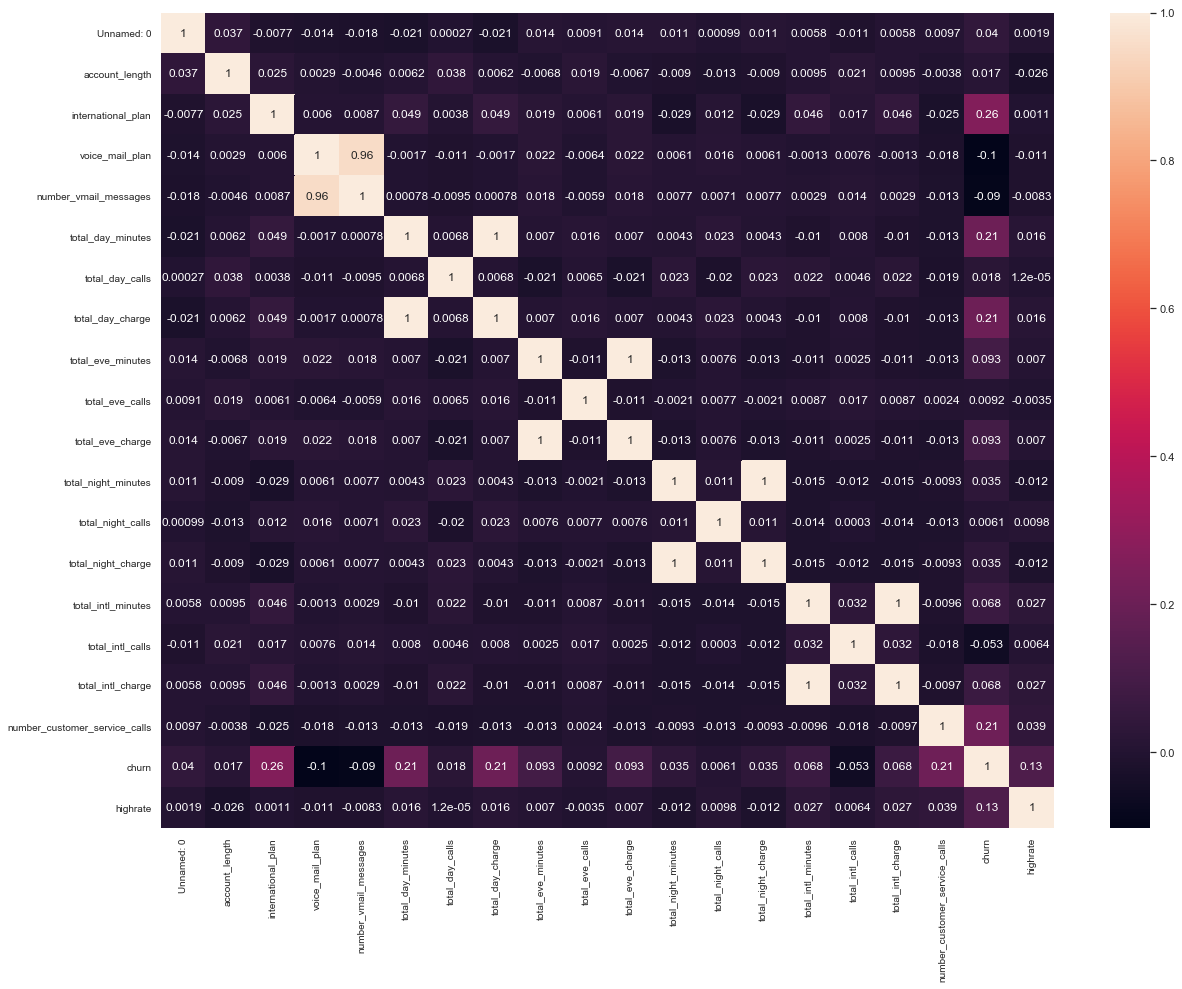

In [12]:
#Correlation heatmap with seaborn
corr = train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

The correlation matrix shows that the total minutes per period of the day (day/eve/night - I am understanding that "day" must be morning and afternoon all together) is totally correlated with the total charge for that period. The same happens with international minutes and charge. It makes sense: you pay as much as you talk. I have to take these correlations into account when I decide which features I'll include in my model. There's also a high correlation between the number of voice mail messages and the voice mail plan. But before droping features I'll run a RFE to see what it gives me. 

In [13]:
#taking a look at the distribution of the data
train.groupby('churn').mean()

,Unnamed: 0,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,highrate
churn,,,,,,,,,,,,,,,,,,,
0,1651.064561,100.793684,0.065263,0.295439,8.604561,175.175754,100.283158,29.780421,199.043298,100.038596,16.918909,200.133193,100.058246,9.006074,10.158877,4.532982,2.743404,1.449825,0.205965
1,1761.028986,102.664596,0.283644,0.165631,5.115942,206.914079,101.335404,35.175921,212.410145,100.561077,18.054969,205.231677,100.399586,9.235528,10.700000,4.163561,2.889545,2.229814,0.356108


It seems that people who canceled the service were talking for more minutes and paying more during the day and in the evenings. Let's take a closer look in these distributions with some visualizations 

In [14]:
#creating a data set with only the mean charge per period of the day 
charge = train[['churn', 'total_day_charge', 'total_eve_charge', 
              'total_night_charge', 'total_intl_charge']]

charge= charge.groupby('churn').mean()

#converting index churn into a variable so I can plot with seaborn
charge=charge.reset_index()
charge.reset_index(inplace=True)

charge.head(5)

,index,churn,total_day_charge,total_eve_charge,total_night_charge,total_intl_charge
0,0,0,29.780421,16.918909,9.006074,2.743404
1,1,1,35.175921,18.054969,9.235528,2.889545


In [15]:
charge= charge.melt(id_vars=["churn", "index"],
                       var_name="period",
                       value_name="mean")

#criating a dictionary to change labels:
names={"period": {"total_day_charge": "day", "total_eve_charge": "evening",
                    "total_night_charge": "night", 
                  "total_intl_charge": "international"},
           "churn": {1: "yes", 0 : "no"}}

#changing the columns in the dataset and taking a look
charge.replace(names, inplace=True)

charge.head(10)

,churn,index,period,mean
0,no,0,day,29.780421
1,yes,1,day,35.175921
2,no,0,evening,16.918909
3,yes,1,evening,18.054969
4,no,0,night,9.006074
5,yes,1,night,9.235528
6,no,0,international,2.743404
7,yes,1,international,2.889545


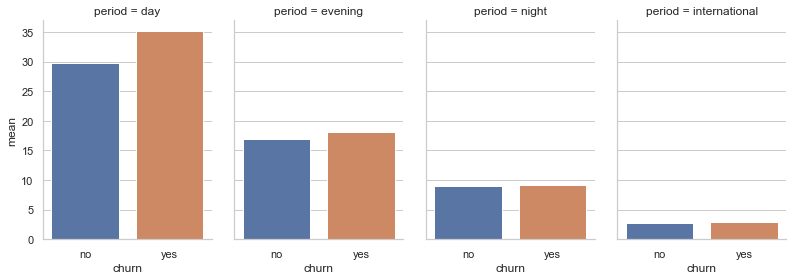

In [16]:
#plotting the mean charge per period of the day
sns.catplot(x="churn", y="mean", col="period", data=charge, kind="bar",
           height=4, aspect=.7)

The graph shows that people is spending more on calls they do during the day. It makes sense because it is the period of the day when they are dealing with professional and personal issues over the phone. Also, the difference in the mean charge among those who stay with the service and those who cancel is higher then in other periods of the day.

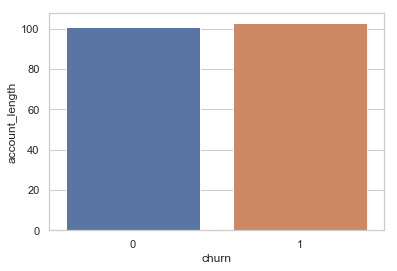

In [17]:
# plotting account lenght

lenght= train[['churn', 'account_length']]
lenght= lenght.groupby('churn').mean()

#converting index churn into a variable so I can plot with seaborn
lenght=lenght.reset_index()
lenght.reset_index(inplace=True)

sns.barplot(x='churn', y='account_length', data=lenght)

Almost no difference in mean account lenght between churn and no churn

[[Text(0,0,'no'), Text(0,0,'yes')]]

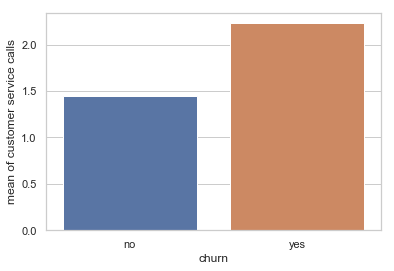

In [18]:
# plotting mean number of customer service calls

serv= train[['churn', 'number_customer_service_calls']]
serv= serv.groupby('churn').mean()

#converting index churn into a variable so I can plot with seaborn
serv=serv.reset_index()
serv.reset_index(inplace=True)

serv_plot=sns.barplot(x='churn', y='number_customer_service_calls', data=serv)
serv_plot.set_ylabel("mean of customer service calls")
serv_plot.set(xticklabels=["no", "yes"]) 

This is intuitive: clients who churned have done more calls to the customer service. They are probably not having their problems solved and are giving up of the service.

[[Text(0,0,'no international plan'), Text(0,0,'has international plan')]]

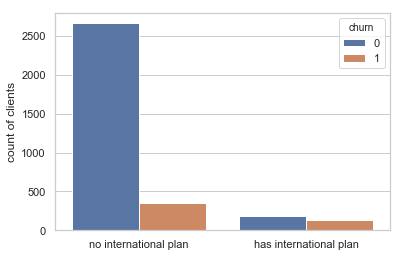

In [19]:
#ploting international plan
int_plot=sns.countplot(x='international_plan', hue='churn', data=train)
int_plot.set_ylabel("count of clients")
int_plot.set_xlabel("")
int_plot.set(xticklabels=["no international plan", "has international plan"])


[[Text(0,0,'no voice mail plan'), Text(0,0,'has voice mail plan')]]

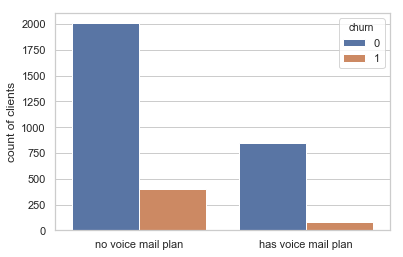

In [20]:
#plotting voice mail plan

voice_plot=sns.countplot(x='voice_mail_plan', hue='churn', data=train)
voice_plot.set_ylabel("count of clients")
voice_plot.set_xlabel("")
voice_plot.set(xticklabels=["no voice mail plan", "has voice mail plan"])

This is an interesting finding: most clients who maintain the service don't have an international or voice mail plan. The descriptive analyses don't show clear pattern among those who cancel the service.

##### Step 2: Feature Selection and Data Processing

In [21]:
#Dropping columns that won't be used

train=train.drop(['Unnamed: 0', 'area_code'], axis=1)
test=test.drop(['Unnamed: 0', 'area_code'], axis=1)

In [22]:
##transforming object data in the test dataset
#with the dictionary I've created above
test.replace(categories, inplace=True)
test.head(5)

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,HI,101,0,0,0,70.9,123,12.05,211.9,73,18.01,236.0,73,10.62,10.6,3,2.86,3,0
1,MT,137,0,0,0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,0
2,OH,103,0,1,29,294.7,95,50.10,237.3,105,20.17,300.3,127,13.51,13.7,6,3.70,1,0
3,NM,99,0,0,0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,0
4,SC,108,0,0,0,197.4,78,33.56,124.0,101,10.54,204.5,107,9.20,7.7,4,2.08,2,0


I have noticed earlier that the churn classes are really unbalanced. It may lead to biased estimation. I'll up-sample the minority class 1 (churn)

In [23]:
#how many 1 do I have in the training data set?
train['churn'].value_counts()


0    2850
1     483
Name: churn, dtype: int64

In [24]:
# Raising the minority class 1 to 2850, the same number of the class 0

train_maj= train[train['churn']==0]
train_min= train[train['churn']==1]

train_min_up= resample(train_min, replace=True, 
                       n_samples=2850, random_state=1)

#Combining resampled results
train_up=pd.concat([train_maj, train_min_up])

train=train_up

train['churn'].value_counts()

1    2850
0    2850
Name: churn, dtype: int64

In [25]:
#up-sampling minority class on test data set

test_maj= test[test['churn']==0]
test_min= test[test['churn']==1]

test_min_up= resample(test_min, replace=True, 
                       n_samples=1443, random_state=1)

#Combining resampled results
test_up=pd.concat([test_maj, test_min_up])

test=test_up

test['churn'].value_counts()

1    1443
0    1443
Name: churn, dtype: int64

In [26]:
## putting the dummy for states with highest churn rates 
#in the test dataset
test['highrate']=0
test['highrate']=test['state'].apply(change_state)

test.head(5)

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,highrate
0,HI,101,0,0,0,70.9,123,12.05,211.9,73,18.01,236.0,73,10.62,10.6,3,2.86,3,0,0
1,MT,137,0,0,0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,0,1
2,OH,103,0,1,29,294.7,95,50.10,237.3,105,20.17,300.3,127,13.51,13.7,6,3.70,1,0,0
3,NM,99,0,0,0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,0,0
4,SC,108,0,0,0,197.4,78,33.56,124.0,101,10.54,204.5,107,9.20,7.7,4,2.08,2,0,1


Finally, it's time to decide which features I'll include in the model. I'll use RFE in a logistic regression model. I'll focus on this basic classification model and take more time on discussing the findings to answer the business question and do recomendations.

In [27]:
cols=['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'highrate']

X=train[cols]
y=train['churn']

model= LogisticRegression()

rfe=RFE(model, 7)
fit=rfe.fit(X, y)

print(train.columns[1:20])
print(rfe.support_)
print(rfe.ranking_)

Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'churn',
       'highrate'],
      dtype='object')
[False  True  True False False False False False False  True False False
  True False False  True  True  True]
[12  1  1  3  5  9 10  6 11  1  8  7  1  4  2  1  1  1]


I ran the RFE and asked for the six most important features that were: international_plan,voice_mail_plan, total_eve_charge, total_night_charge, total_intl_minutes, number_customer_service_calls, highrate. Total international charge is highly correlated with total international minutes, so I didn't add it to the model. Number of voice mail messages is highly correlated with voice mail messages, so it was not included. Total international calls was not correlated to any other features, so I decided to include it.


In [28]:
#Here are the features I'll be add to the model
cols2=['international_plan','voice_mail_plan', 'total_eve_charge', 
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'number_customer_service_calls', 'highrate']

X_new=train[cols2]


Since I'll run a logistic model I have to standardize the features to have mean=0 and standard deviation=1

In [29]:
#creating array with the X from the second model
x_train= X_new.values

#creating array with the X for the test dataset
X_test_new=test[cols2]
x_test= X_test_new.values

In [30]:
#applying the scaler
scaler_x_train = StandardScaler().fit(x_train)
x_train_st = scaler_x_train.transform(x_train)

scaler_x_test = StandardScaler().fit(x_test)
x_test_st = scaler_x_test.transform(x_test)

#summarizing the transformed data
print(x_train_st[0:3, :])
print(x_test_st[0:3, :])

[[-0.46014638  1.83607343 -0.16423981  0.85306334 -0.16200902 -0.53240488
  -0.52641615 -0.61710125]
 [-0.46014638  1.83607343 -0.20052491  1.05130917  1.16540751 -0.53240488
  -0.52641615 -0.61710125]
 [-0.46014638 -0.54464053 -1.63378632 -0.80949827  0.62726567  0.2703217
  -1.1548082   1.62047962]]
[[-0.46053855 -0.46715687  0.17041799  0.66386908  0.04899333 -0.48882457
   0.67298348 -0.58401889]
 [-0.46053855 -0.46715687  0.82197919 -2.06022489 -0.35166157  1.06272638
  -1.23054182  1.71227337]
 [-0.46053855  2.14060857  0.67305091  1.89782387  1.17811169  0.67483864
  -0.59603339 -0.58401889]]


In [31]:
#Finally preparing for prediction. Unifying terminology because it's
#a bit confusing right now

#X
x_train=x_train_st
x_test=x_test_st

#Y

y_train=train['churn'].values
y_test=test['churn'].values


##### Step 3: Prediction and Accuracy

Finally, it's time to train the machine!!

In [32]:
# Creating a Logistic Regression
model = LogisticRegression()
model.fit(x_train, y_train)
result_train= model.score(x_train, y_train)

print("Accuracy: %.3f%%" % (result_train * 100.0))


Accuracy: 71.667%


It's a good accuracy score. Now let's apply the model in the test data set

In [33]:
# Score in the test data

result = model.score(x_test, y_test)
print("Accuracy: %.3f%%" % (result * 100.0))

Accuracy: 71.414%


The model maintained basically the same accurancy in the test data set. Now I'll look how it performed with more detail with a classification report and a confusion matrix.

Accuracy of logistic regression classifier on test set: 0.71
             precision    recall  f1-score   support

          0       0.70      0.75      0.73      1443
          1       0.73      0.67      0.70      1443

avg / total       0.72      0.71      0.71      2886



Text(0.5,12.5,'Predicted label')

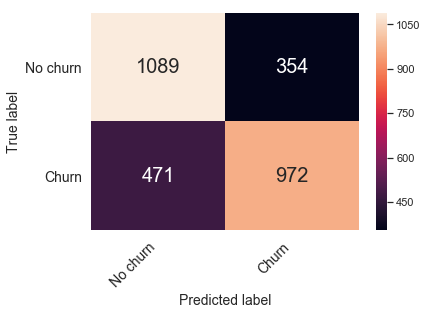

In [34]:
#y_test = real values
#y_pred = predicted values

y_pred= model.predict(x_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(x_test,y_test)))
print(classification_report(y_test,y_pred))
 

confusion_matrix_df = pd.DataFrame(confusion_matrix, ('No churn', 'Churn'), ('No churn', 'Churn'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

The model predicted around 71% of the cases correctly. But we should be cautions with those 29% of cases that were wrongly predicted. For the business point of view those cases that were predicted as churn but the clients actually didn't cancel the service (354) are not a problem since it didn't lose these clients. However, we should be concerned with those cases that were predicted as no churn and the client actually churned. In these cases the business is losing clients and the model is not predicting it. In my model these cases correspond to 16% of the data set (471/2886). It's not a huge error.   

##### Conclusions 

A really simple classification algorithm provided a good accuracy and was efficient enough for the analysis. In a real business environment the data scientist would try other algorithms to reduce false positives and negatives, specially if the model was being prepared be to deployed and make real-time predictions. In this case the model should be really well calibrated since it reinforces its own learning as new data get in the data set and new predictions are made. 

The analysis showed that some features are really important to understand customer churn in this business. 

Having an international plan, the duration in minutes of the international calls and number of international calls made played and important role on churn. Interestingly these features were not correlated as I was expecting, so all three features should be understood as reasons for possible churn. 

Having a voice mail plan is also a reason for churning. 

The total charge at night also affects churn. Actually the graphs in the descriptive analysis show that clients who churned were paying more for the services in every period of the day analysed.

As we could expect, clients who churned called more to the customer service

#### Recommendations

Based on the findings I would give the following recommendations for the business manager:

###### Rethink the international plan. 

1. For the international plan, she should study the possibility of increasing the number of minutes and calls for the same charge or reducing the charge of the plan.  

2. If possible, she should think about applying a survey with customers to understand their use of the international plan. Are they using it for business? Do they travel abroad frequently? For which countries they call more frequently? Special plans could be created for specific needs. 

3. She should rethink the way they are entering data in their database: a valuable information would be to know the period of the day clients are doing more international calls. 

###### Rethink the voice mail plan

In a real life situation the data scientist would have gathered all the information about the business and the types of plans from the manager before and during the analysis. In this sense, I don't know if there's a limit of voice messages and how much would additional messages would cost. Taking it into account, I would give the following recommendations:

1. If the plan limits the number of messages maybe the quantity is not being enough for the clients. As recommended for the international plan, the manager should study the possibility of increasing the number of voice mail messages maintaining the actual charge.

2. It also would be good to know if the client needs this service for work so special offers could be made based on specific needs. 

###### Re-evaluate charges based on period of the day

The descriptive/exploratory analysis showed that the mean charge per period of the day was higher among those clients who churned. The manager should consider re-evaluating the charge of the plans.

###### Re-evaluate customer service

It is intuitive that clients that are not satisfied and can't solve their issues with the customer service will probably churn. However, a good customer service may make they reconsider cancelling the service. 

###### Evaluate the service on states with high rates of churn

Some states have really high churn rates. I've added a dummy to control for the states that have more than 20% churn rate. The manager should be concerned about service deficiencies in these areas or other companies that are offering better services and are stirring up competition in these states.

###### Finally, investing in a survey with clients would be beneficial in order to rethink the business.

This survey should assess customer satisfaction with the service and use habits. It should include:

1. Customer main use of the service: business or personal use?
2. Customer satisfaction with the quality of the service. Is the transmission good? Are the calls clear? If there's an internet service, does it work ok?
3. Don't forget to collect information about the location from where the client is using the service. The company probaby has these records.
3. Customer satisfaction with customer service. Are they satisfied? Think about ways to improve it. Ask customers their main issues with the customer service. Think about the whole administrative process and how the team is answering the calls to think on possible problems to evaluate in the survey
4. Customer use of international plan: Does it use regularly? For what purpose? Business or personal use? Which period of the day the client uses usually makes international calls?

I wouldn't ask what the client think about the prices because she will always prefer to pay less and have better services. I would recommend the manager to apply the survey to both clients and customer who churned. Of course it would probably be more difficult to have responses from people that churned but an email could be sent saying that the company is sorry to see the client go and would like to know about her experience for further improvements. In both cases (churn and no churn) there should be an open space for those clients to write their observations. This can bring more insight about what customers think about the services. With the survey data in hand the manager will have more information about how to redesign the business.  